# Training and Model Comparison

---

This notebook contains the code necessary to train agents to solve the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### Prerequisites
It is highly recommended to follow [these steps](https://github.com/udacity/Value-based-methods#dependencies) to set up the environment. Some highlights to what's expected to run this notebook:
To run this notebook, it is expected to have the following elements:
  - [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md).
  - Dependencies installed (`pip install -r requirements.txt`)
  - Banana environment installed and placed in this same directory (`./Banana.app`)


### Configure all agents

For this experiment, we will train and compare multiple implementations of the DQN, each including different improvements. The implementations that will be compared here are:
- **Vanilla DQN:** The original implementation of Deep Q Networks.
- **Dueling DQN:** A variation of DQN where the network has two heads, one for learning the state value and the other for learning the action advantage for that state.
- **Double DQN:** A variation of DQN where the maximal action is selected by the local network, but evaluated by the target network.
- **Priority Sweeping:** An improvement on how experience replay is done, where experience with higher opportunity for learning is given preference.
- **Rainbow DQN:** All of the above in a single agent.

In [1]:
from unityagents import UnityEnvironment
from dqn_agent import DQNAgent
from experience_replay import MemoryBuffer, PriorityBuffer
from value_estimators import VanillaEstimator, DoubleDQNEstimator
from networks import VanillaQNetwork, DuelingQNetwork
import numpy as np

def memory_config_generator(local_model, target_model, gamma=0.99):
	return {
    "max_size": int(1e5),
	"local_model": local_model,
	"target_model": target_model,
	"estimator": estimator,
	"gamma": gamma,
	"epsilon": 1e-5,
	"priority_amount": 0.2,
}

# Initialize the environment
env = UnityEnvironment(file_name="/Users/aristizabal-factored/Documents/Value-based-methods/p1_navigation/Banana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
state_size = len(env_info.vector_observations[0])
action_size = brain.vector_action_space_size

agents_dict = {
	"VanillaDQN": {
		"network": VanillaQNetwork,
		"estimator": VanillaEstimator,
		"memory": MemoryBuffer,
	},
	"DuelingDQN": {
		"network": DuelingQNetwork,
		"estimator": VanillaEstimator,
		"memory": MemoryBuffer,
	},
	"DoubleDQN": {
		"network": VanillaQNetwork,
		"estimator": DoubleDQNEstimator,
		"memory": MemoryBuffer,
	 },
	"PrioritySweepDQN": {
		"network": VanillaQNetwork,
		"estimator": VanillaEstimator,
		"memory": PriorityBuffer,
	},
	"RainbowDQN": {
		"network": DuelingQNetwork,
		"estimator": DoubleDQNEstimator,
		"memory": PriorityBuffer,
	}
}

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Train and compare
Having configured the agents, we can run the experiment for each of them and obtain some information about their performance compared to each other.

In [2]:
gamma = 0.99
hidden_layers = [128, 128, 64, 64, 64, 32, 32]

for agent_name, agent_config in agents_dict.items():
	Network = agent_config["network"]
	Estimator = agent_config["estimator"]
	Memory = agent_config["memory"]

	local_model = Network(state_size, action_size, hidden_layers=hidden_layers)
	target_model = Network(state_size, action_size, hidden_layers=hidden_layers)

	estimator = Estimator()

	memory_config = memory_config_generator(local_model, target_model)
	memory = Memory(memory_config)
	agent = DQNAgent(env, estimator, local_model, target_model, memory)
	print("Running experiment with agent {}".format(agent_name))
	agent.train(episodes=1250, epsilon=0.2, max_steps=int(1e8), lr=1e-4, alpha=0.001)
	print("Saving agent and rewards")
	model_path = "checkpoints/{}.pth".format(agent_name)
	rewards_path = "checkpoints/{}_rewards.npz".format(agent_name)
	agent.save(model_path)
	rewards = np.array(agent.rewards)
	np.savez(rewards_path, rewards)

Running experiment with agent VanillaDQN


Avg Reward: 0.37 | Epsilon 0.065:  30%|███       | 377/1250 [09:23<21:45,  1.50s/it]


KeyboardInterrupt: 

## Load and plot
We can observe how they did during train time. We are interested in seeing improvements in convergence time

In [29]:
rewards_dict = {}
rolling_rewards_dict = {}

for agent in agents_dict.keys():
	with np.load(f"checkpoints/{agent}_rewards.npz") as rewards:
		rewards = rewards["arr_0"]
		rewards_dict[agent] = rewards
		rolling_rewards = []
		for i in range(1, len(rewards)-1):
			window = rewards[max(i-100, 0):i].mean()
			rolling_rewards.append(window)
		rolling_rewards_dict[agent] = rolling_rewards

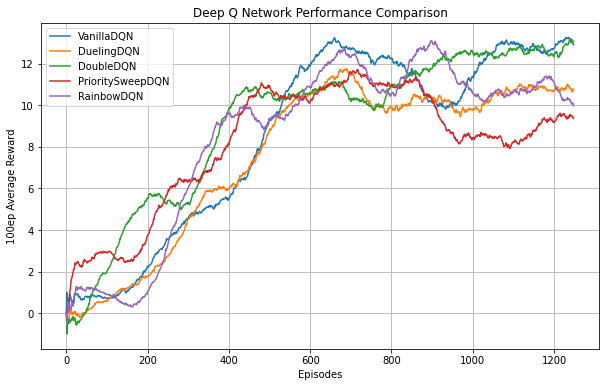

In [41]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
for agent, avg_rewards in rolling_rewards_dict.items():
	x = list(range(len(avg_rewards)))
	plt.plot(x, avg_rewards, label=agent)

plt.title("Deep Q Network Performance Comparison")
plt.xlabel("Episodes")
plt.ylabel("100ep Average Reward")

plt.legend(loc="upper left")
plt.grid()
plt.show()

## Conclusion:
From the plots above, we can conclude a few things:
1. Performance is relatively the same for all agents
2. In terms of reaching the highest amount of average reward, VanillaDQN and DoubleDQN appear to excel, with RainbowDQN reaching but not staying in the top.
3. In terms of stability, DoubleDQN appears to increase in a relatively stable manner. PrioritySweepDQN seems really unstable, reaching the lowest average reward near the end of the learning period.
4. Training time was exponentially higher for agents using PrioritySweepMemory. This may be an implementation detail

## Next Steps:
This are some points that could be improved to get better insights and improve results:
1. Run multiple instances of all the agents to get a more robust performance metric. Comparing performance between single execution of each agent is really prone to noise influencing the conclusions.
2. Optimize PrioritySweepMemory. Currently it uses deque for storing experience. This, and the fact that we have to sort experience every n steps, may be the cause of loss in performance. Implementations with numpy or similar could greatly improve execution time.
3. 